# Critical Scale Invariance in a Healthy Human Heart Rate

### Description

In this project you will analyse from a physics perspective time series of human heart rate. You will demonstrate the robust scale-invariance in the probability density function (PDF) of detrended healthy human heart rate increments. Moreover, you will show that such increments are not Gaussian distributed, but they display fat tails. This scale-independent and fractal structure supports the view that a healthy human heart rate is controlled to converge continually to a critical state.

### References

* Original paper: https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.93.178103


### Assignment

1. build the cumulative time series B(i) from the detrended and normalised heart beat time series b(i)
2. Do a polynomial fit of B(i)
3. Calculate the  increments (fluctuation) from the polynomial fit
4. Build the increments PDF and fit it with Gaussian and non Gaussian distributions.
5. Test the scale invariance of the PDFs by collapse plot



### Contacts

Samir Suweis <samir.suweis@unipd.it>

In [94]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from obspy.signal.detrend import polynomial
from scipy.optimize import curve_fit



In [95]:
#list the files
filelist = os.listdir("rr_data_file")
#read them into pandas
df_list = [pd.read_csv(f'rr_data_file/{file}',delimiter = "\t",names=[f'{file}']) for file in filelist]
min_len = min(map(len, df_list))
small_df = pd.concat(df_list,axis=1)
big_df = (small_df.T).apply(pd.to_numeric, errors='coerce')
cropped_df = big_df.iloc[:,:min_len]
batch1 = cropped_df.iloc[:,:int(cropped_df.shape[1]/2)]
batch2 = cropped_df.iloc[:,int(cropped_df.shape[1]/2):]

In [96]:
#Reject the outliers
def reject_outliers(data):
    cleaned_rows = np.zeros((data.shape[0],data.shape[1]))
    N = data.shape[0]
    for i in range(N):
        
        row_data = data.iloc[i, :]

        row_mean = np.mean(row_data)
        row_std = np.std(row_data)
    
        threshold = 3
        lower_bound = row_mean - threshold * row_std
        upper_bound = row_mean + threshold * row_std
    
        outliers = np.logical_or(row_data < lower_bound, row_data > upper_bound)
    
        cleaned_row = np.where(outliers, np.nan, row_data)
        
        cleaned_rows[i,:] = np.array(cleaned_row)

    cleaned_data = pd.DataFrame(np.array(cleaned_rows))
    return cleaned_data
batch1_cld = reject_outliers(batch1)
batch2_cld = reject_outliers(batch2)

In [97]:
#integrating
df_cum1 = batch1.cumsum(axis = 1, skipna = True)
df_cum2 = batch2.cumsum(axis = 1, skipna = True)
df_cum1_cld = batch1_cld.cumsum(axis = 1, skipna = True)
df_cum2_cld = batch2_cld.cumsum(axis = 1, skipna = True)

# Remove non-stationarity of the data by local detrending and differencing


In [98]:
# Remove non-stationarity of the data by local detrending and differencing
def detrend(df, s_vals, p_order):
  '''
  Input:
  df : DataFrame containing interbeat times (RR intervals) in ms for different people in each row
  s_vals : defines the size of the segment over which the detrending and temporal correlation is done
  p_order : polynomial degree for detrending
  Output: 
  List of numpy-Arrays containing the detrended increments of all analyzed people for various values of s
  '''
  Delta_S=[] #stores the detrended data of all patients for every s 
  for idx, s in enumerate(s_vals): #iterate over different values of s
    Delta_S_B=[]
    for j in range(df.shape[0]): #iterate over the number of patients
      row = df.iloc[j,:]
      intval = int(np.floor(df.shape[1]/(2*s))) # maximum numbers of 2*s intervals in the data series
      for i in range(intval):
        polynomial(row[i*2*s:(i+1)*2*s],p_order, plot =False)    # polynomial detrending, modifies data inplace
      polynomial(row[intval*2*s:],p_order, plot =False)
      Delta_S_B_p=np.array([row[i+s]-row[i] for i in range(intval*2*s) if i+s< df.shape[1]])
      Delta_S_B.append(Delta_S_B_p/np.std(Delta_S_B_p))  # append the normalized data divided by its std deviation
    Delta_S.append(np.array(Delta_S_B).flatten())
  return Delta_S

In [99]:
# Define values of s and perform detrending on datasets
s_vals = [2**i for i in range(3,13)]
q = 3 #polynomial degree
Delta_S = detrend(df_cum1,s_vals, q)

In [100]:
# Fitting Gaussian to the data
def gauss(x, A, mu, sigma):
    return A/np.sqrt(2*np.pi*sigma**2)*np.exp(-(x - mu)**2 / (2*sigma**2)) 

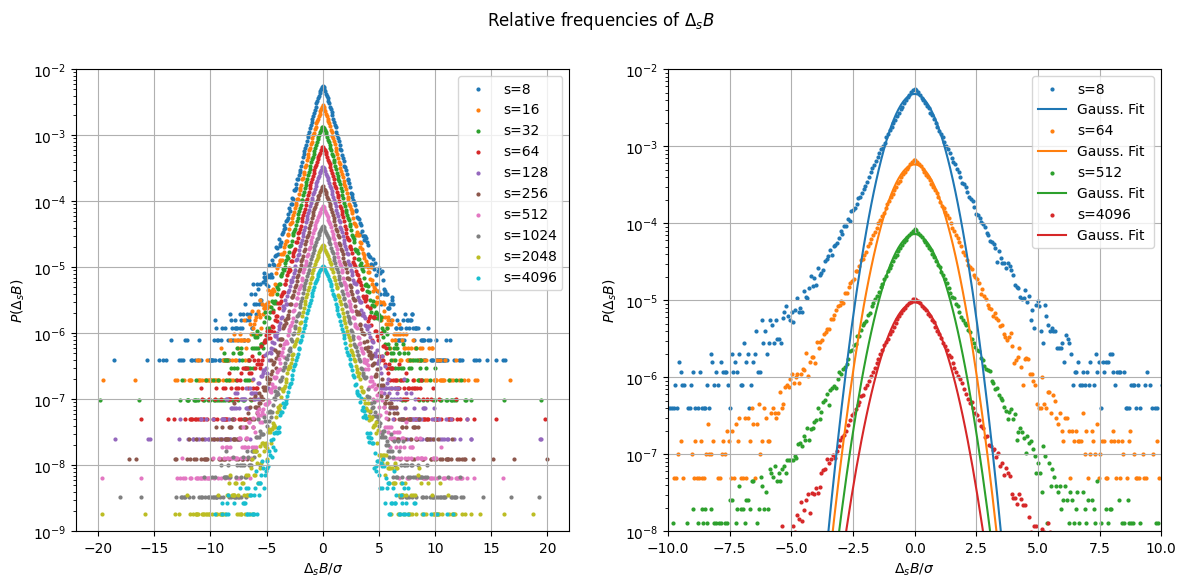

In [101]:
# Plot the PDF of the integrated detrended increments
fig, ax = plt.subplots(1,2, figsize = (14,6))
x = np.linspace(-20, 20, 400)
for idx, s in enumerate(s_vals):
    n=len(Delta_S[idx])
    histogram, bins = np.histogram(Delta_S[idx], bins=int(np.sqrt(n)), range=(-20,20))
    bin_centers = (bins[:-1] + bins[1:]) / 2
    popt, pcov = curve_fit(gauss , bin_centers, histogram/(s*n), p0=[1,1,1])
    ax[0].scatter(bin_centers, histogram/(n*s), label=f's={s}', s=4, marker='o')
    if idx%3==0 or idx == 9:
        ax[1].scatter(bin_centers, histogram/(n*s), label=f's={s}', s=4, marker='o')
        ax[1].plot(x, gauss(x, *popt), label=f'Gauss. Fit ')
plt.suptitle('Relative frequencies of $\Delta_sB$')
ax[0].set_yscale('log')
ax[0].set_xlabel('$\Delta_sB/\sigma$')
ax[0].set_ylabel('$P(\Delta_sB)$')
ax[0].set_ylim(1e-9, 10**(-2))
ax[0].legend()
ax[0].grid(True)

ax[1].set_yscale('log')
ax[1].set_xlim((-10,10))
ax[1].set_xlabel('$\Delta_sB/\sigma$')
ax[1].set_ylabel('$P(\Delta_sB)$')
ax[1].set_ylim(1e-8, 10**(-2))
ax[1].legend()
plt.grid(True)
plt.show()


''' We are examining the sum of s detrended healthy interbeat intervals,
 but the more significant quantity is detrended interbeat interval
'''


In [103]:
def detrend_inc(df, s_vals, p_order):
  '''
  Input:
  df : DataFrame containing interbeat times (RR intervals) in ms for different people in each row
  s_vals : defines the size of the segment over which the detrending and temporal correlation is done
  p_order : polynomial degree for detrending
  Output: 
  List of numpy-Arrays containing the detrended increments of all analyzed people for various values of s
  '''
  Delta_S=[] #stores the detrended data of all patients for every s 
  for idx, s in enumerate(s_vals): #iterate over different values of s
    Delta_S_B=[]
    for j in range(df.shape[0]): #iterate over the number of patients
      row = df.iloc[j,:]
      intval = int(np.floor(df.shape[1]/(2*s))) # maximum numbers of 2*s intervals in the data series
      for i in range(intval):
        polynomial(row[i*2*s:(i+1)*2*s],p_order, plot =False)    # polynomial detrending, modifies data inplace
      polynomial(row[intval*2*s:],p_order, plot =False)
      Delta_S_B_p=np.array([row[j+i+1]-row[j+i] for i in range(2*s-1) for j in range(intval)])
      Delta_S_B_n=np.array([Delta_S_B_p[i+s]-Delta_S_B_p[i] for i in range(len(Delta_S_B_p)) if i+s< len(Delta_S_B_p)])
      Delta_S_B.append(Delta_S_B_n/np.std(Delta_S_B_n))  # append the normalized data divided by its std deviation
    Delta_S.append(np.array(Delta_S_B).flatten())

  return Delta_S
# Define values of s and perform detrending on datasets
s_vals = [2**i for i in range(3,8)]
Delta_S = detrend_inc(df_cum1,s_vals, q)

    


[0.005420481489841697, 0.006922281361056423, 0.005124073580955831, 0.00659840382937368, 0.005347463651306886]


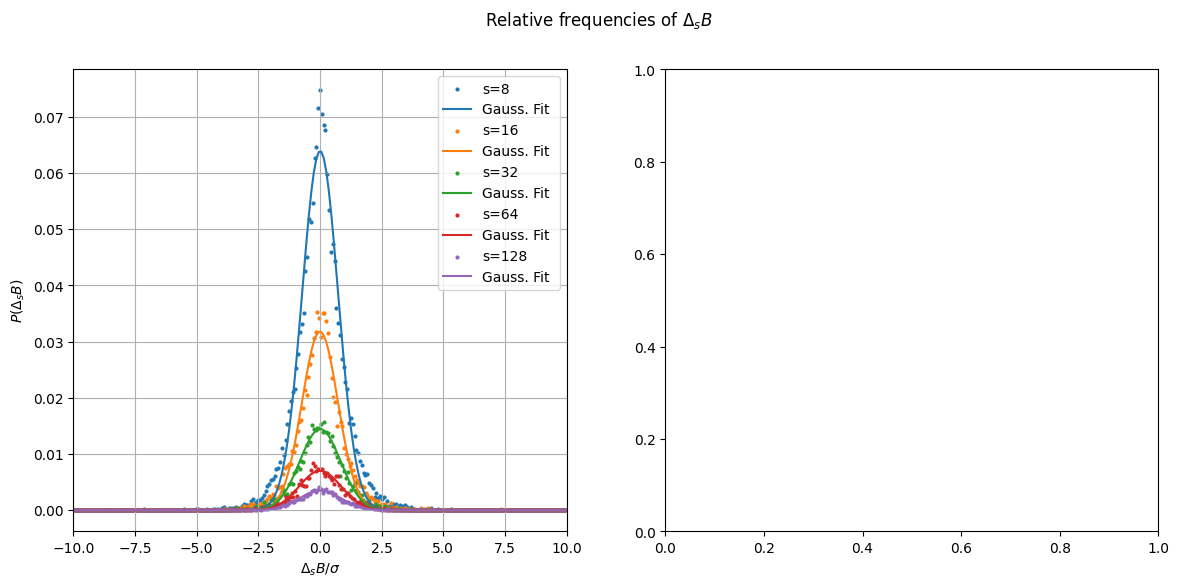

In [113]:
from scipy.stats import moments

fig, ax = plt.subplots(1,2, figsize = (14,6))
x = np.linspace(-20, 20, 400)
moms =[]
for idx, s in enumerate(s_vals):
    n=len(Delta_S[idx])
    s_mom=[]
    histogram, bins = np.histogram(Delta_S[idx], bins=int(np.sqrt(n)), range=(-20,20), density =True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    ax[0].scatter(bin_centers, histogram/(s), label=f's={s}', s=4, marker='o')
    ax[0].set_xlim(-10,10)
    popt, pcov = curve_fit(gauss , bin_centers, histogram, p0=[0.1,0,2])
    ax[0].plot(x, gauss(x, *popt)/s, label=f'Gauss. Fit ')
    for p in range(1,6)
        s_mom.append((Delta_S[idx], moment=p))
    moms.append(np.array(s_mom))
ax[1].plot(np)

plt.suptitle('Relative frequencies of $\Delta_sB$')
ax[0].set_xlabel('$\Delta_sB/\sigma$')
ax[0].set_ylabel('$P(\Delta_sB)$')
ax[0].legend()
ax[0].grid(True)